In [1]:
from tqdm import tqdm
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.config import PCT_VALUES
from workflow.external.gtdb_metadata import GtdbMetadataR207

In [2]:
DF = RemoveGuncFailedContigsByContaminationSpCluster().output().read_cached()
print(DF.shape)

UNQ_GIDS = set(DF.index.get_level_values(0))

print(f'{len(UNQ_GIDS):,} failed gids')
DF.head()

(578539, 5)
35,723 failed gids


new_sp_rep      ani        af    type  same
gid             pct                                                  
GCA_000143435.1 1    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                5    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                15   GCF_001435955.1  97.6349  0.829228  sp_rep  True
GCA_000153745.1 5                NaN      NaN       NaN  no_ani  True
GCA_000155005.1 1    GCF_003697165.2  96.5203  0.827668  sp_rep  True

In [3]:
from workflow.external.gtdb_metadata import GtdbMetadataR207

DF_META = GtdbMetadataR207().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,gtdb_type_species_of_genus,ncbi_taxonomy,ncbi_taxonomy_unfiltered,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,d__Bacteria;x__Terrabacteria group;p__Firmicut...,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,t,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,t,d__Archaea;p__Nanoarchaeota;c__;o__Nanoarchaea...,d__Archaea;x__DPANN group;p__Nanoarchaeota;o__...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


types:
no_af = no alignment fraction <0.5
no_ani = novel species cluster
sp_rep = found species representative within ANI radius


In [4]:

def get_cutoff_at_which_sp_cluster_changed():

    df_changed = DF[DF['same'] == False]

    print(df_changed.shape)
    print(df_changed.head())

    cutoff_vals = list()
    gids = list()
    gids_seen = set()
    types = list()
    new_sp_rep = list()

    print('gid\tcutoff\ttype\tnew_sp_rep\tprev_sp\tis_sp_rep')
    for (gid, pct), row in df_changed.iterrows():
        if gid in gids_seen:
            continue
        gids_seen.add(gid)
        gids.append(gid)

        cutoff_vals.append(pct)
        types.append(row['type'])
        new_sp_rep.append(row['new_sp_rep'])

        cur_gid = gid
        cur_cutoff = pct
        cur_type = row['type']
        cur_new_sp_rep = row['new_sp_rep']

        meta_row = DF_META.loc[cur_gid]
        expected_sp = meta_row['species']
        is_sp_rep = meta_row['gtdb_representative'] == 't'


        print(f'{cur_gid}\t{cur_cutoff}\t({cur_type})\t{cur_new_sp_rep}\t{expected_sp}\t{is_sp_rep}')

    print(f'Found {len(gids):,} gids')
    # print(cutoff_vals)
    # print(gids)
    # print(types)
    # print(new_sp_rep)


    return


get_cutoff_at_which_sp_cluster_changed()


(2130, 5)
                          new_sp_rep      ani        af    type   same
gid             pct                                                   
GCA_000761495.1 1    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                2    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                3    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                4    GCF_014769185.1  96.2558  0.854244  sp_rep  False
                5    GCF_014769185.1  96.2490  0.848708  sp_rep  False
gid	cutoff	type	new_sp_rep	prev_sp	is_sp_rep
GCA_000761495.1	1	(sp_rep)	GCF_014769185.1	s__Acinetobacter idrijaensis	True
GCA_001509115.1	50	(no_ani)	nan	s__Mesotoga sp003228205	False
GCA_001543395.1	47	(sp_rep)	GCA_902786745.1	s__Limimorpha sp001543395	True
GCA_002171475.2	21	(sp_rep)	GCA_002728075.1	s__TMED96 sp002171475	True
GCA_002291775.1	15	(sp_rep)	GCA_002712565.1	s__UBA822 sp002731735	False
GCA_002313235.1	42	(sp_rep)	GCA_002712565.1	s__UBA822 sp002731735	False
GCA_002450535.1	6	(

In [5]:
from collections import defaultdict


def gen_data():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed.reset_index()
    df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]

    d_pct_to_changes = defaultdict(list)

    d_pct_to_sp_type = defaultdict(lambda: defaultdict(set))

    for cur_pct in PCT_VALUES:
        df_subset = df_changed[df_changed['pct'] == cur_pct]

        for _, row in df_subset.iterrows():
            gid = row['gid']

            meta_row = DF_META.loc[gid]
            is_rep = meta_row['gtdb_representative'] == 't'
            is_type = meta_row['gtdb_type_designation'] != 'not type material'

            cur_sp = meta_row['species']
            if ' sp' in cur_sp or len(cur_sp.split('_')) == 3:
                d_pct_to_sp_type[cur_pct]['placeholder'].add(gid)
            else:
                d_pct_to_sp_type[cur_pct]['named'].add(gid)

            if is_rep:
                change_type = 'representative changed species'
            else:
                if row['type'] == 'no_af' or row['type'] == 'no_ani':
                    change_type = 'novel_sp_cluster'
                else:
                    change_type = 'species changed'

            d_pct_to_changes[cur_pct].append(change_type)

    print(len(d_pct_to_sp_type[50]['placeholder']))
    print(len(d_pct_to_sp_type[50]['named']))

    return d_pct_to_changes

data = gen_data()


145
33


1 19
5 30
10 55
15 77
20 90
30 115
40 139
50 178


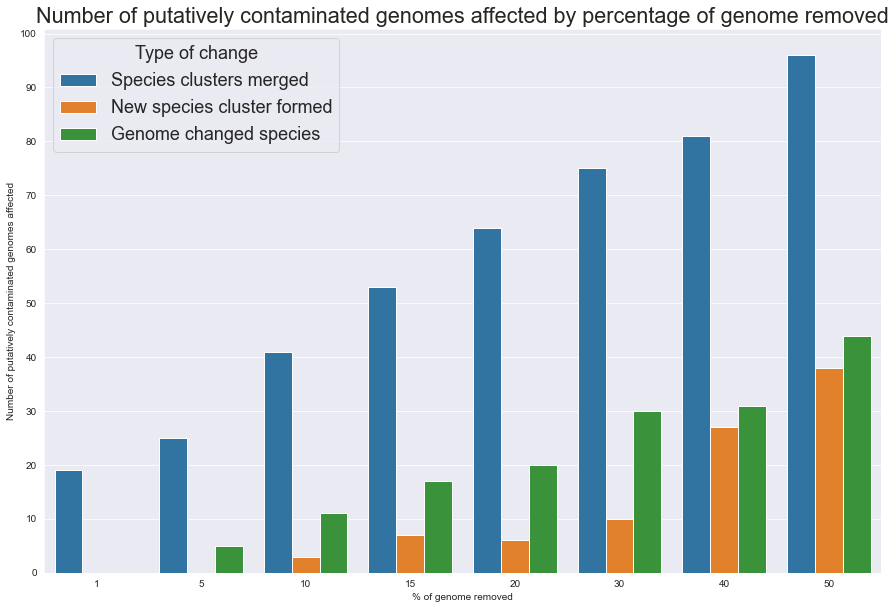

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def make_plot():

    rows = list()

    for k, v in data.items():
        print(k, len(v))
        cnts = Counter(v)
        rows.append({
            'pct': k,
            'value': cnts.get('representative changed species', 0),
            'Type of change': 'Species clusters merged'
        })
        rows.append({
            'pct': k,
            'value': cnts.get('novel_sp_cluster', 0),
            'Type of change': 'New species cluster formed'
        })
        rows.append({
            'pct': k,
            'value': cnts.get('species changed', 0),
            'Type of change': 'Genome changed species'
        })

    df = pd.DataFrame(rows)


    # df = df[df['pct'] <= 10]
    # df['value'] = df['value']


    fig, ax = plt.subplots(figsize=(15, 10))

    plt.rcParams['svg.fonttype'] = 'none'

    ax.grid(True)
    plt.rcParams.update({'font.size': 18})
    sns.barplot(data=df, x='pct', y='value', hue='Type of change', ax=ax)
    ax.set_ylabel('Number of putatively contaminated genomes affected')
    ax.set_xlabel('% of genome removed')

    ax.set_yticks(list(range(0, 110, 10)))

    plt.title('Number of putatively contaminated genomes affected by percentage of genome removed')

    plt.savefig('/tmp/sp_clustering_changes.svg')


    # ax.set_xticks(list(range(120, 10)))
    # ax.set_xticklabels(list(range(120, 10)))

    return



make_plot()

In [7]:
[x for x in DF_META.columns]

['ambiguous_bases',
 'checkm_completeness',
 'checkm_contamination',
 'checkm_marker_count',
 'checkm_marker_lineage',
 'checkm_marker_set_count',
 'checkm_strain_heterogeneity',
 'coding_bases',
 'coding_density',
 'contig_count',
 'gc_count',
 'gc_percentage',
 'genome_size',
 'gtdb_genome_representative',
 'gtdb_representative',
 'gtdb_taxonomy',
 'gtdb_type_designation',
 'gtdb_type_designation_sources',
 'gtdb_type_species_of_genus',
 'ncbi_taxonomy',
 'ncbi_taxonomy_unfiltered',
 'domain',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species']

In [8]:
# from collections import defaultdict
#
#
# def gen_data():
#
#     # Some were originally run with more pct values, but just reduce to the analysis set
#     df_changed = DF[DF['same'] == False]
#     df_changed = df_changed.reset_index()
#     df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]
#
#     d_pct_to_changes = defaultdict(list)
#
#     out = dict()
#
#     for cur_pct in PCT_VALUES:
#         df_subset = df_changed[df_changed['pct'] == cur_pct]
#         df_subset = df_subset.sort_values(by=['gid', 'pct'], ascending=[True, False])
#
#         gids_to_print = set()
#         gids_done = set()
#
#         d_type_to_source = defaultdict(list)
#
#         for _, row in df_subset.iterrows():
#             gid = row['gid']
#             if gid in gids_done:
#                 continue
#             gids_done.add(gid)
#
#             meta_row = DF_META.loc[gid]
#             is_rep = meta_row['gtdb_representative'] == 't'
#             is_type = meta_row['gtdb_type_designation'] != 'not type material'
#
#             if is_rep:
#                 change_type = 'representative changed species'
#             else:
#                 if row['type'] == 'no_af' or row['type'] == 'no_ani':
#                     change_type = 'novel_sp_cluster'
#                 else:
#                     change_type = 'species changed'
#
#             d_pct_to_changes[cur_pct].append(change_type)
#
#             ncbi_genome_cat = meta_row['ncbi_genome_category']
#             if ncbi_genome_cat == 'none':
#                 genome_cat = 'Isolate'
#             elif ncbi_genome_cat == 'derived from metagenome':
#                 genome_cat = 'MAG'
#             elif ncbi_genome_cat == 'derived from single cell':
#                 genome_cat = 'SAG'
#             elif ncbi_genome_cat == 'derived from environmental sample':
#                 genome_cat = 'ENV'
#             else:
#                 raise ValueError('Unknown ncbi_genome_cat: {}'.format(ncbi_genome_cat))
#
#             d_type_to_source[change_type].append(genome_cat)
#
#
#             if change_type == 'novel_sp_cluster':
#                 gids_to_print.add(gid)
#
#         out[cur_pct] = d_type_to_source
#
#         print(cur_pct)
#         print(gids_to_print)
#         print('-' * 10 + '^' * 10 + str(len(gids_to_print)) + '-' * 10)
#
#     return out
#
# data = gen_data()


In [9]:
# def plot_data():
#
#     rows = list()
#     for cur_pct, d_values in data.items():
#
#         all_values = list()
#         [all_values.extend(v) for v in d_values.values()]
#
#         for k, v in d_values.items():
#             cnts = Counter(v)
#             print(cur_pct)
#             for a, b in cnts.items():
#                 print(k, a, b)
#
#     #
#     #     cnts = Counter(all_values)
#     #     rows.append({
#     #         'pct': cur_pct,
#     #         'value': cnts.get('Isolate', 0),
#     #         'Type of change': 'Isolate'
#     #     })
#     #     rows.append({
#     #         'pct': cur_pct,
#     #         'value': cnts.get('ENV', 0),
#     #         'Type of change': 'ENV'
#     #     })
#     #     rows.append({
#     #         'pct': cur_pct,
#     #         'value': cnts.get('MAG', 0),
#     #         'Type of change': 'MAG'
#     #     })
#     #     rows.append({
#     #         'pct': cur_pct,
#     #         'value': cnts.get('SAG', 0),
#     #         'Type of change': 'SAG'
#     #     })
#     #
#     #
#     # df = pd.DataFrame(rows)
#     #
#     # fig, ax = plt.subplots(figsize=(15, 10))
#     #
#     # ax.grid(True)
#     # plt.rcParams.update({'font.size': 18})
#     # sns.barplot(data=df, x='pct', y='value', hue='Type of change', ax=ax)
#     # ax.set_ylabel('Number of putatively contaminated genomes affected')
#     # ax.set_xlabel('% of genome removed')
#     #
#     # plt.show()
#
#
#
#     return
#
# plot_data()